
# Bayesian Simple Linear Regression via Gibbs Sampling
This notebook analyzes the simulated clinical trial dataset (dosage ∝ 1/x) using a Gibbs sampler, answering the motivating clinical questions:

- **Parameter question:** $P(\beta > 0 \mid y,x)$  
- **Variance question:** Posterior for $\sigma_\epsilon^2$ (residual variance)  
- **Predictive question:** For a new patient at $x_\star = 50$ mg, compute $p(y_\star \mid x_\star, y, x)$ and $P(y_\star \ge 5\,\mathrm{mmHg} \mid x_\star=50, y, x)$


## 1. Load dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Load the data (update the path if needed)
# Replace 'path/to/your/file.csv' with the actual path to your file in Google Drive
csv_path = "/content/drive/My Drive/ColabNotebooks/Biostat682_Fall2025/data/SBP_clinical_trial.csv" # Make sure this path is correct for your file in Google Drive

df = pd.read_csv(csv_path)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,dosage_mg,bp_reduction_mmhg
0,50,2.6
1,25,-0.7
2,25,4.8
3,50,4.2
4,50,8.4


## 2. Precompute summary statistics (sufficient for Gibbs updates)

In [2]:
# Extract data into numpy arrays and compute summary statistics
y = df["bp_reduction_mmhg"].to_numpy()
x = df["dosage_mg"].to_numpy().astype(float)

n = len(y)

# Sufficient statistics for the likelihood
Sx   = np.sum(x)
Sxx  = np.sum(x**2)
Sy   = np.sum(y)
Sxy  = np.sum(x*y)
Syy  = np.sum(y**2)

n, Sx, Sxx, Sy, Sxy, Syy

(100000,
 np.float64(6505925.0),
 np.float64(1144436875.0),
 np.float64(721227.7000000001),
 np.float64(104566500.0),
 np.float64(12297546.61))


## 3. Prior specification (in **precision** form)
We use the conjugate priors (matching the slide notation):

- $\alpha \sim N(0,\, \tau_\alpha^{-2})$  
- $\beta \sim N(0,\, \tau_\beta^{-2})$  
- $\tau^2_\epsilon \sim \mathrm{Gamma}(a_\epsilon, b_\epsilon)$

> Note: $\sigma_\epsilon^2 = 1/\tau_\epsilon^2$.


In [3]:
# Hyperparameters for the prior distributions (feel free to adjust to be weakly-informative)
tau_alpha2 = 1e-4  # prior precision for alpha (intercept)
tau_beta2  = 1e-4  # prior precision for beta (slope)
a_eps = 1.0        # shape parameter for tau_epsilon^2 (precision of errors)
b_eps = 1.0        # rate parameter for tau_epsilon^2

tau_alpha2, tau_beta2, a_eps, b_eps

(0.0001, 0.0001, 1.0, 1.0)

## 4. SSE as a function of $(\alpha,\beta)$ using summary statistics

In [4]:
# Function to calculate the Sum of Squared Errors (SSE) given alpha, beta, and summary statistics
def SSE(alpha, beta, n, Sx, Sxx, Sy, Sxy, Syy):
    # SSE(alpha,beta) = sum_i (y_i - alpha - beta x_i)^2
    return (Syy - 2*alpha*Sy - 2*beta*Sxy + 2*alpha*beta*Sx
            + n*alpha**2 + beta**2*Sxx)

# Quick check of the SSE function at alpha=0 and beta=0
SSE(0.0, 0.0, n, Sx, Sxx, Sy, Sxy, Syy)

np.float64(12297546.61)

## 5. Gibbs sampler implementation

In [5]:
# Implement the Gibbs sampler
rng = np.random.default_rng(123) # Initialize a random number generator

T = 12000     # total iterations for the sampler
burn = 2000   # number of initial iterations to discard (burn-in period)
keep = T - burn # number of iterations to keep for analysis

# Arrays to store the draws of the parameters
alpha_draws = np.empty(T)
beta_draws  = np.empty(T)
tau2_draws  = np.empty(T)  # tau_epsilon^2 (precision of errors)

# Initialize the parameter values
alpha = 0.0
beta  = 0.0
tau2  = 1.0   # initial precision

# Gibbs sampling loop
for t in range(T):
    # Update alpha | beta, tau2, y,x ~ Normal
    # Calculate the posterior precision and mean for alpha
    tau2_alpha_tilde = n * tau2 + tau_alpha2
    mu_alpha_tilde = (tau2 * (Sy - beta * Sx)) / tau2_alpha_tilde
    # Draw a new value for alpha from its posterior normal distribution
    alpha = rng.normal(mu_alpha_tilde, np.sqrt(1.0 / tau2_alpha_tilde))

    # Update beta | alpha, tau2, y,x ~ Normal
    # Calculate the posterior precision and mean for beta
    tau2_beta_tilde = tau2 * Sxx + tau_beta2
    mu_beta_tilde = (tau2 * (Sxy - alpha * Sx)) / tau2_beta_tilde
    # Draw a new value for beta from its posterior normal distribution
    beta = rng.normal(mu_beta_tilde, np.sqrt(1.0 / tau2_beta_tilde))

    # Update tau2 | alpha, beta, y,x ~ Gamma(a+n/2, b+SSE/2)
    # Calculate the SSE for the current alpha and beta
    sse = SSE(alpha, beta, n, Sx, Sxx, Sy, Sxy, Syy)
    # Calculate the shape and rate parameters for the posterior gamma distribution of tau2
    shape = a_eps + n/2.0
    rate  = b_eps + 0.5 * sse
    # Draw a new value for tau2 from its posterior gamma distribution
    # numpy's gamma function uses shape-scale, so we use 1.0/rate for scale
    tau2 = rng.gamma(shape, 1.0 / rate)

    # Store the draws
    alpha_draws[t] = alpha
    beta_draws[t]  = beta
    tau2_draws[t]  = tau2

# Discard burn-in samples and store the remaining samples
alpha_samps = alpha_draws[burn:]
beta_samps  = beta_draws[burn:]
tau2_samps  = tau2_draws[burn:]
sigma2_samps = 1.0 / tau2_samps  # Calculate residual variance (sigma^2 = 1/tau^2)
# Print the number of samples kept after burn-in
len(alpha_samps)

10000

## 6. Basic diagnostics (trace plots)

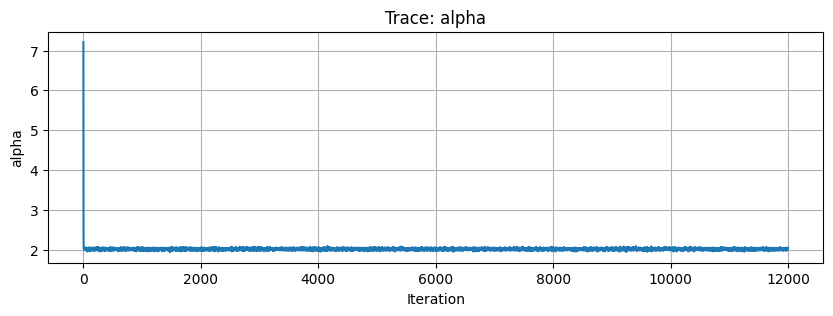

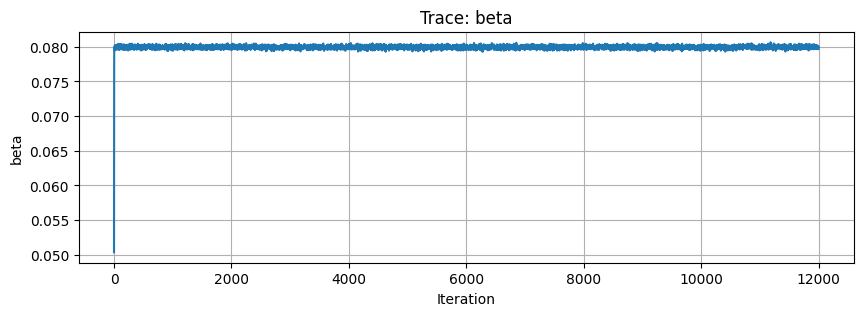

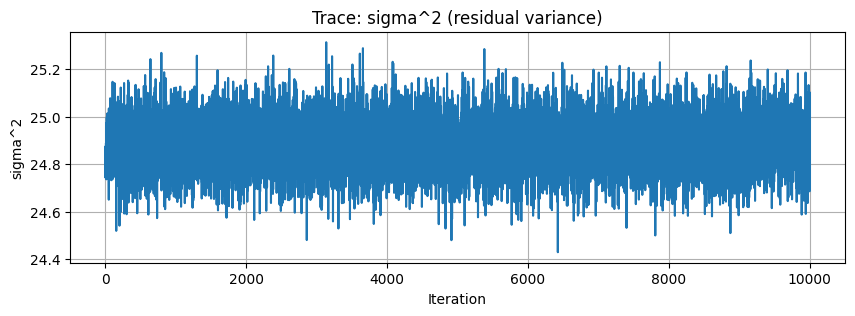

In [6]:
# Generate trace plots to diagnose convergence of the sampler
plt.figure(figsize=(10,3))
plt.plot(alpha_draws) # Plot trace for alpha
plt.title("Trace: alpha")
plt.xlabel("Iteration")
plt.ylabel("alpha")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(beta_draws) # Plot trace for beta
plt.title("Trace: beta")
plt.xlabel("Iteration")
plt.ylabel("beta")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(sigma2_samps) # Plot trace for sigma^2
plt.title("Trace: sigma^2 (residual variance)")
plt.xlabel("Iteration")
plt.ylabel("sigma^2")
plt.grid(True)
plt.show()


## 7. Clinical questions
### 7.1 Is the treatment effect positive?  $P(\beta>0\mid y,x)$


In [7]:
# Calculate the posterior probability that beta is greater than 0
p_beta_pos = np.mean(beta_samps > 0)
# Calculate the posterior mean of beta
beta_mean = np.mean(beta_samps)
# Calculate the 95% credible interval for beta
beta_ci = np.quantile(beta_samps, [0.025, 0.975])
# Display the results
p_beta_pos, beta_mean, beta_ci

(np.float64(1.0),
 np.float64(0.07993158039007855),
 array([0.07956912, 0.0802965 ]))


### 7.2 How uncertain are we about residual variability? Posterior for $\sigma_\epsilon^2$
We summarize by posterior mean and 95% credible interval.


In [8]:
# Calculate the posterior mean of sigma^2 (residual variance)
sigma2_mean = np.mean(sigma2_samps)
# Calculate the 95% credible interval for sigma^2
sigma2_ci = np.quantile(sigma2_samps, [0.025, 0.975])
# Display the results
sigma2_mean, sigma2_ci

(np.float64(24.883582725309704), array([24.66329323, 25.10505673]))


### 7.3 Posterior predictive for a new patient at $x_\star=50$ mg
Compute the predictive distribution and $P(y_\star\ge 5\,\mathrm{mmHg} \mid x_\star=50, y,x)$.


In [9]:
# Posterior predictive analysis for a new patient at a specific dosage (x_star)
x_star = 50.0 # New patient's dosage
# Draw predictive samples for y* using posterior draws of alpha, beta, and sigma^2
# y* | theta ~ Normal(alpha + beta x*, sigma^2)
y_star = rng.normal(alpha_samps + beta_samps * x_star, np.sqrt(sigma2_samps))
# Calculate the posterior probability that y* is greater than or equal to 5.0
p_y_star_ge_5 = np.mean(y_star >= 5.0)
# Calculate the posterior mean of y*
y_star_mean = np.mean(y_star)
# Calculate the 95% credible interval for y*
y_star_ci = np.quantile(y_star, [0.025, 0.975])
# Display the results
p_y_star_ge_5, y_star_mean, y_star_ci

(np.float64(0.5779),
 np.float64(5.992163073251351),
 array([-3.69243668, 15.92061205]))


## 8. (Optional) Visualization: posterior predictive vs. data (subsample for plotting)


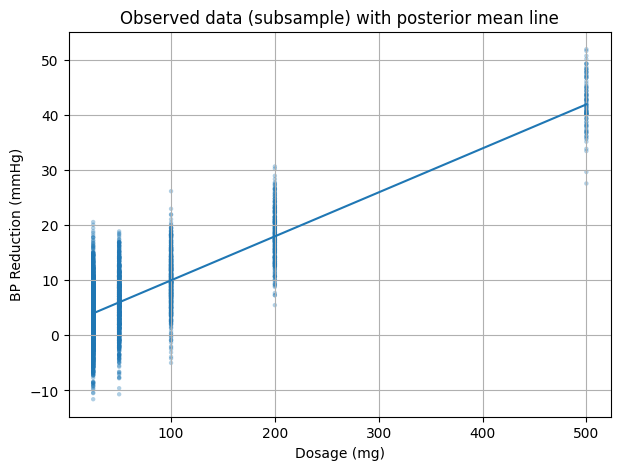

In [10]:
# (Optional) Visualization: plot observed data (subsample) with the posterior mean regression line
# Subsample the data for better visibility in the plot
sub = df.sample(4000, random_state=123)

plt.figure(figsize=(7,5))
# Scatter plot of the subsampled observed data
plt.scatter(sub["dosage_mg"], sub["bp_reduction_mmhg"], s=10, alpha=0.35, edgecolor="none")
plt.xlabel("Dosage (mg)")
plt.ylabel("BP Reduction (mmHg)")
plt.title("Observed data (subsample) with posterior mean line")

# Plot the posterior mean regression line (using posterior means of alpha and beta)
alpha_hat = np.mean(alpha_samps) # Posterior mean of alpha
beta_hat = np.mean(beta_samps)   # Posterior mean of beta
xs = np.array([25, 500], dtype=float) # X values for plotting the line
ys = alpha_hat + beta_hat * xs # Corresponding Y values based on the posterior mean line
plt.plot(xs, ys) # Plot the regression line
plt.grid(True)
plt.show()


## 9. Summaries
- $P(\beta>0\mid y,x)$ computed above.
- Posterior mean and 95% CI for $\beta$ and $\sigma_\epsilon^2$.
- Predictive distribution at $x_\star=50$ mg with $P(y_\star\ge5)$.
Adjust prior hyperparameters in Section 3 as needed.
